In [ ]:
!rm -rf dso-560-nlp-text-analytics && git clone https://github.com/ychennay/dso-560-nlp-text-analytics

Cloning into 'dso-560-nlp-text-analytics'...
remote: Enumerating objects: 3177, done.
remote: Total 3177 (delta 0), reused 0 (delta 0), pack-reused 3177
Receiving objects: 100% (3177/3177), 94.48 MiB | 18.46 MiB/s, done.
Resolving deltas: 100% (394/394), done.
Checking out files: 100% (3185/3185), done.


In [ ]:
%cd dso-560-nlp-text-analytics

/content/dso-560-nlp-text-analytics


# Attention and Transformers

The original *Attention Is All You Need* paper is [available here](https://arxiv.org/pdf/1706.03762.pdf).

The overall architecture of the **Transformer** model is defined here from the paper:
![transformers](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/transformers.png?raw=1)

## Define Configurations

In [ ]:
VOCAB_SIZE = 20000

In [ ]:
from keras.layers import Input, Dense, LSTM, Flatten, concatenate, Activation, RepeatVector, Permute
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
import numpy as np 
import spacy
nlp = spacy.load('en_core_web_sm', disable=["pos", "ner", "tagger"])

## Load in Amazon Reviews Dataset

In [ ]:
import numpy as np
NUM_SAMPLES = 2000

good_reviews = open("datasets/good_amazon_toy_reviews.txt").readlines()
bad_reviews = open("datasets/poor_amazon_toy_reviews.txt").readlines()

sampled_good_reviews = good_reviews[:NUM_SAMPLES]
sampled_bad_reviews = bad_reviews[:NUM_SAMPLES]

docs = sampled_good_reviews + sampled_bad_reviews
labels = np.concatenate([np.ones(NUM_SAMPLES), np.zeros(NUM_SAMPLES)])

## Remove Stopwords

In [ ]:
stopwords_removed_docs = list(
    map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), docs))

## Tokenize Text

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=10_000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(stopwords_removed_docs)

## Integer Encode Documents

In [ ]:
from typing import List
def get_max_token_length_per_doc(docs: List[List[str]])-> int:
    return max(list(map(lambda x: len(x.split()), docs)))

# get the max length in terms of token length
max_length = get_max_token_length_per_doc(docs)
print(f"Max length of sequences is {max_length}")

def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 100
# integer encode the documents
encoded_docs = integer_encode_documents(stopwords_removed_docs, tokenizer)
# this is a list of lists, the numbers represent the index position of that word.
# for instance, 33 means the 33rd word in the vocabulary
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

Max length of sequences is 817


## Load in GloVe Vectors
Download the actual Glove vectors from S3 and unzip them.

In [ ]:
!wget https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
!unzip glove6b100dtxt.zip 

--2022-04-27 00:44:53--  https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
Resolving dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)... 54.231.113.251
Connecting to dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)|54.231.113.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137847651 (131M) [application/zip]
Saving to: ‘glove6b100dtxt.zip’

glove6b100dtxt.zip  100%[===================>] 131.46M  33.7MB/s    in 4.5s    

2022-04-27 00:44:58 (29.5 MB/s) - ‘glove6b100dtxt.zip’ saved [137847651/137847651]

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [ ]:
import numpy as np
def load_glove_vectors():
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


## Load in Embeddings Matrix

In [ ]:
# create a weight matrix for words in training docs
VOCAB_SIZE = 20_000
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

## Define an LSTM Model

In [ ]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking
from keras.layers import Embedding
import keras
def make_lstm_classification_model(plot=False, sequence_length = 100, vocab_size = 20000):
    model = keras.models.Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=sequence_length, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(LSTM(units=64, input_shape=(1, sequence_length)))
    model.add(Dense(16))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

## Inside One LSTM Cell
![LSTM](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/lstm_architecture.jpg?raw=1)

In [ ]:
lstm_model = make_lstm_classification_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 masking (Masking)           (None, 100, 100)          0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,043,297
Trainable params: 43,297
Non-trainable params: 2,000,000
_________________________________________________________________


## Split Into Train/Test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)

#### Train LSTM Model

In [ ]:
# fit the model
history = lstm_model.fit(padded_docs, labels, validation_split = 0.1, epochs=3, verbose=1)

Epoch 1/3
113/113 [==============================] - 59s 459ms/step - loss: 0.4192 - accuracy: 0.8183 - val_loss: 0.3170 - val_accuracy: 0.8975
Epoch 2/3
113/113 [==============================] - 49s 438ms/step - loss: 0.2905 - accuracy: 0.8836 - val_loss: 0.3597 - val_accuracy: 0.8700
Epoch 3/3
 44/113 [==========>...................] - ETA: 29s - loss: 0.2562 - accuracy: 0.8949

In [ ]:
import matplotlib.pyplot as plt # From https://keras.io/visualization/


def plot_performance(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_performance(history)

# Ways to Improve Performance

* **feature engineer** the text by grouping collocated tokens, removing stopwords, etc.

* **use K-Folds cross-validation** to "use" more of the dataset in the training/validation/testing process.

* **train your own custom domain-specific embeddings** (instead of using generic pre-trained ones)

* **tune hyperparameters** - neural network architecture, activation functions, etc. 

* **enrich the data** using augmented datasets as features

## Self Attention Model

Let's define a function to generate our self attention model. We'll install another library that augments Keras and creates self attention layers for us to use called `keras_self_attention` ([Github](https://pypi.org/project/keras-self-attention/)).

In [ ]:
!pip install keras_self_attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=537140e782bc0f82ee0640d37b4bf6f91465b3769ae05e712c3449cae8015320
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [ ]:
from keras_self_attention import SeqSelfAttention
def make_self_attention_model(vocab_size=20_000, sequence_length = 100):
    model = keras.models.Sequential()
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=sequence_length, trainable=False))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=300,
                                                           return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(keras.layers.Dense(units=1))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )
    model.summary()
    return model

### Notes:

Each LSTM has a hidden state and memory. You can ask `keras` to return the vectors that represent these sequences by using:

#### Difference Between `return_sequences` and `return_states`

```python
LSTM(HIDDEN_STATE_DIMENSIONS, return_sequences=True)
```

If you had a `SEQUENCE_LENGTH` of **20**, and a `HIDDEN_STATE_DIMENSIONS` of **64**, then you'll produce a matrix of shape `64 x 20` as your `return_sequence`.

On the other hand, `return_states` will return both the memory cells (`c`) as well as the hidden state `h`:

```
lstm, state_h, state_c = LSTM(..., return_state=True)
```

Here, `lstm` will be your LSTM model, `state_h` is your hidden state, and `state_c` is your cell memory state. 

Example from [Keras Returning Hidden State in RNNs](http://digital-thinking.de/keras-returning-hidden-state-in-rnns/):
```
inputs1 = Input(shape=(5, 1))
lstm1, state_h, state_c = LSTM(1, return_state=True, return_sequences=True)(inputs1)
model = Model(inputs=inputs1, outputs=[lstm1, state_h, state_c])
data = array([0.1, 0.2, 0.3, 0.4, 0.5]).reshape((1,5,1))
print(model.predict(data))
```
The output of this is
```
[array([[[0.00734747],
        [0.02000349],
        [0.03651035],
        [0.05576567],
        [0.07689518]]], dtype=float32), array([[0.07689518]], dtype=float32), array([[0.15496857]], dtype=float32)]
```

## Model High-Level Architecture
![architecture](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/lstm_arch.png?raw=1)

In [ ]:
attention_model = make_self_attention_model()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          2000000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 100, 600)         962400    
 nal)                                                            
                                                                 
 seq_self_attention_5 (SeqSe  (None, 100, 600)         38465     
 lfAttention)                                                    
                                                                 
 dense_7 (Dense)             (None, 100, 1)            601       
                                                                 
Total params: 3,001,466
Trainable params: 1,001,466
Non-trainable params: 2,000,000
_________________________________________________________________


In [ ]:
attention_history = attention_model.fit(padded_docs, labels,validation_split = 0.1, epochs=5, verbose=1)

Epoch 1/5
113/113 [==============================] - 8s 40ms/step - loss: 1.0213 - accuracy: 0.4962 - val_loss: 0.6415 - val_accuracy: 0.8314
Epoch 2/5
113/113 [==============================] - 2s 21ms/step - loss: 0.7009 - accuracy: 0.5129 - val_loss: 0.6851 - val_accuracy: 0.5744
Epoch 3/5
113/113 [==============================] - 2s 21ms/step - loss: 0.6921 - accuracy: 0.5311 - val_loss: 0.8791 - val_accuracy: 0.0000e+00
Epoch 4/5
113/113 [==============================] - 2s 21ms/step - loss: 0.6914 - accuracy: 0.5365 - val_loss: 0.8941 - val_accuracy: 0.0000e+00
Epoch 5/5
113/113 [==============================] - 2s 21ms/step - loss: 0.6917 - accuracy: 0.5406 - val_loss: 0.8507 - val_accuracy: 0.0000e+00


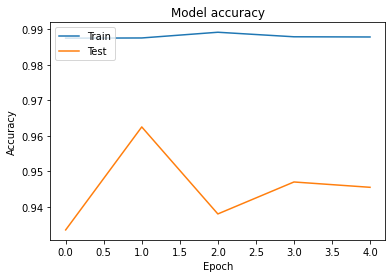

In [ ]:
plot_performance(attention_history)

In [ ]:
weights = attention_model.get_weights()
print(f"The sequence length is {MAX_SEQUENCE_LENGTH}.")
print(f"The input is of shape {X_train.shape}.")
print(f"The vocabulary size is {VOCAB_SIZE}.")
print(f"The word embedding dimensions size is 100.")
print(f"The hidden state dimension size is {MAX_SEQUENCE_LENGTH}.")

weight_purposes = ["word_embeddings", 
                   "data_gate_weights", 
                   "hidden_state_gate_weights",
                   "attention "]

for weights in attention_model.get_weights():
    print(np.array(weights).shape)

The sequence length is 100.
The input is of shape (3200, 100).
The vocabulary size is 20000.
The word embedding dimensions size is 100.
The hidden state dimension size is 100.
(20000, 100)
(100, 1200)
(300, 1200)
(1200,)
(100, 1200)
(300, 1200)
(1200,)
(600, 32)
(600, 32)
(32,)
(32, 1)
(1,)
(600, 1)
(1,)


# BERT (Bi-Directional Encoder Representations of Transformers)

## High Level Architecture

![bert](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/bert_architecture.png?raw=1)

![comparison](https://github.com/ychennay/dso-560-nlp-text-analytics/blob/main/images/bert.webp?raw=1)